In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cftime
from xmip.preprocessing import rename_cmip6
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy as sp
import pandas as pd

# ERA5 data and HadCRUT data

## ERA5 Temperature

In [4]:
ds = xr.open_dataset('RA_data/ERA5-2m.nc')

yrs = np.arange(1940,2025,1) # full from 1940 to 2024 incl
n_yrs = len(yrs)
n_mons = n_yrs*12
mons = np.arange(0,n_mons,1)  # indices of months from jan 1940 to dec 2024 - avoiding the incomplete 2025

era5_monthly = ds.isel(valid_time = mons)

def get_ITD_era5_avgfirst(hist):
    weights = np.cos(np.deg2rad(hist.latitude))
    NH = hist.sel(latitude = slice(90,0)).weighted(weights).mean(dim=['longitude', 'latitude'])
    SH = hist.sel(latitude = slice(0,-90)).weighted(weights).mean(dim=['longitude', 'latitude'])
    NH_yr = NH.groupby('valid_time.year').mean('valid_time')
    SH_yr = SH.groupby('valid_time.year').mean('valid_time')
    ITD = NH_yr-SH_yr
    return ITD, weights, NH_yr, SH_yr

ITD_era5, weights_era5, NH_era5, SH_era5  = get_ITD_era5_avgfirst(era5_monthly)
ITD_era5_10 = ITD_era5.rolling(year=10, center=True).mean().dropna("year")
NH_era5_10 = NH_era5.rolling(year=10, center=True).mean().dropna("year")
SH_era5_10 = SH_era5.rolling(year=10, center=True).mean().dropna("year")

era5_means = (NH_era5_10 + SH_era5_10) /2

## ERA5 Precipitation

In [5]:
'''
ds = xr.open_dataset('RA_data/ERA5-precip.nc')
ds = ds.isel(valid_time = np.arange(0,(2025-1940)*12, 1))
era5_precip_full = ds.groupby('valid_time.year').mean('valid_time')
era5_prec_yrly = era5_precip_full.sel(year = slice(1940,2024))

# era5 precip is m daily / grid and models are kg m-2 s-1
# kg m-2 = mm / area
# so, era5 precip: 

s_in_month = (60*60*24)
mm_in_m = 1000

era5_precip = (era5_prec_yrly * mm_in_m) / s_in_month
'''

"\nds = xr.open_dataset('RA_data/ERA5-precip.nc')\nds = ds.isel(valid_time = np.arange(0,(2025-1940)*12, 1))\nera5_precip_full = ds.groupby('valid_time.year').mean('valid_time')\nera5_prec_yrly = era5_precip_full.sel(year = slice(1940,2024))\n\n# era5 precip is m daily / grid and models are kg m-2 s-1\n# kg m-2 = mm / area\n# so, era5 precip: \n\ns_in_month = (60*60*24)\nmm_in_m = 1000\n\nera5_precip = (era5_prec_yrly * mm_in_m) / s_in_month\n"

In [6]:
ds = xr.open_dataset('RA_data/ERA5-precip.nc')
ds = ds.isel(valid_time = np.arange(0,(2025-1940)*12, 1))
era5_precip_full = ds.groupby('valid_time.year').mean('valid_time')
era5_prec_yrly = era5_precip_full.sel(year = slice(1940,2024))

# era5 precip is m daily / grid and models are kg m-2 s-1
# wanna keep it daily though
# so, era5 precip: 

#s_in_month = (60*60*24)
#mm_in_m = 1000

era5_precip = era5_prec_yrly  # * mm_in_m

## HadCRUT

In [7]:
hc = xr.open_dataset('RA_data/Hadcrut/HadCRUT-global.nc')
NH_hc = xr.open_dataset('RA_data/Hadcrut/HadCRUT-NH.nc')
SH_hc = xr.open_dataset('RA_data/Hadcrut/HadCRUT-SH.nc')

years = hc['time'].dt.year
hc.coords['time'] = years
NH_hc.coords['time'] = years
SH_hc.coords['time'] = years

In [8]:
ITD_hc = NH_hc - SH_hc
ITD_hc_10 = ITD_hc.tas_mean.rolling(time=10, center=True).mean()
NH_hc_10 = NH_hc.tas_mean.rolling(time=10, center=True).mean()
SH_hc_10 = SH_hc.tas_mean.rolling(time=10, center=True).mean()

# Data from models

## Loading T files

In [9]:
ITDs_mean = []
NHs_mean = []
SHs_mean = []
GMTs_mean = []
patterns = []
data_list = [ITDs_mean, NHs_mean, SHs_mean, GMTs_mean, patterns]
names = ['ITDs', 'NHs', 'SHs', 'GMTs', 'patterns']


for data in range(len(data_list)):        
    for i in os.listdir(f'inter_files/{names[data]}/'):
        filepath = f'inter_files/{names[data]}/{i}'
        if 'ipynb' in filepath:
            print('ipynb_checkpoint idk what that is')
        else:
            file = xr.open_dataset(filepath)
            data_list[data].append(file)
        

era5_means = (NH_era5_10 + SH_era5_10) /2
hc_mean = hc.tas_mean.rolling(time=10, center = True ).mean()


ipynb_checkpoint idk what that is
ipynb_checkpoint idk what that is
ipynb_checkpoint idk what that is
ipynb_checkpoint idk what that is
ipynb_checkpoint idk what that is


## Loading P files

In [10]:
glob_pr = []
trop_pr = []
centroids = []
data_list = [glob_pr, trop_pr, centroids]
names = ['glob_pr', 'trop_pr', 'centroids']

for data in range(len(data_list)):        
    for i in os.listdir(f'inter_files_precip/{names[data]}/'):
        filepath = f'inter_files_precip/{names[data]}/{i}'
        file = xr.open_dataset(filepath)
        file = file.sel(year = slice(1850, 2096)) # because already 10yr averaged
        data_list[data].append(file)


# IHTD plot

## preparing varibales to plot

In [11]:
pi_base, pi_base_str = slice(1940,1960), '1940-1960'

In [12]:
# GMTs anomalies:

GMTs_anom = []
for i in GMTs_mean:
    anom = i - np.mean(i.sel(year = pi_base))
    GMTs_anom.append(anom)

GMT_era5_anom = era5_means - np.mean(era5_means.sel(year = pi_base))
GMT_hc_anom = hc_mean - np.mean(hc_mean.sel(time = pi_base))


In [13]:
# IHTD anomalies

ITDs_anom = []
for i in ITDs_mean:
    anom = i - np.mean(i.sel(year = pi_base))
    ITDs_anom.append(anom)

era5_anom = ITD_era5_10 - np.mean(ITD_era5_10.sel(year = slice (1940,1960)))
hc_anom = ITD_hc_10 - np.mean(ITD_hc_10.sel(time = pi_base))

In [14]:
# ITDs throuhg present era5

present_era5 = ITD_era5_10.t2m[-1]

ITDs_through_present = []
ITDs_through_present_before = []
ITDs_through_present_after = []
for i in ITDs_mean:
    s= range(len(ITDs_mean))
    diff = i.sel(year = 2020).tas - present_era5
    i_through_present = i - diff
    i_bef = i_through_present.sel(year = slice(1850,2020))
    i_after = i_through_present.sel(year = slice(2020,2100))
    ITDs_through_present.append(i_through_present)
    ITDs_through_present_before.append(i_bef)
    ITDs_through_present_after.append(i_after)


In [15]:
cols = [
    'purple', 'brown', 'coral', 'plum', 'skyblue', 'steelblue', 
    'limegreen', 'goldenrod', 'yellowgreen', 'peru', 'slateblue', 'palevioletred',
    'khaki', 'teal', 'chocolate', 'darkcyan', 'blue', 'green'
]

## plot

<>:41: SyntaxWarning: invalid escape sequence '\c'
<>:42: SyntaxWarning: invalid escape sequence '\c'
<>:43: SyntaxWarning: invalid escape sequence '\c'
<>:44: SyntaxWarning: invalid escape sequence '\c'
<>:41: SyntaxWarning: invalid escape sequence '\c'
<>:42: SyntaxWarning: invalid escape sequence '\c'
<>:43: SyntaxWarning: invalid escape sequence '\c'
<>:44: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_575/304294848.py:41: SyntaxWarning: invalid escape sequence '\c'
  axes[0].set_ylabel('Temperature ($^\circ$C)')
/tmp/ipykernel_575/304294848.py:42: SyntaxWarning: invalid escape sequence '\c'
  axes[3].set_ylabel('Temperature difference ($^\circ$C)')
/tmp/ipykernel_575/304294848.py:43: SyntaxWarning: invalid escape sequence '\c'
  axes[1].set_ylabel('Temperature difference ($^\circ$C)')
/tmp/ipykernel_575/304294848.py:44: SyntaxWarning: invalid escape sequence '\c'
  axes[2].set_ylabel('Temperature difference ($^\circ$C)')


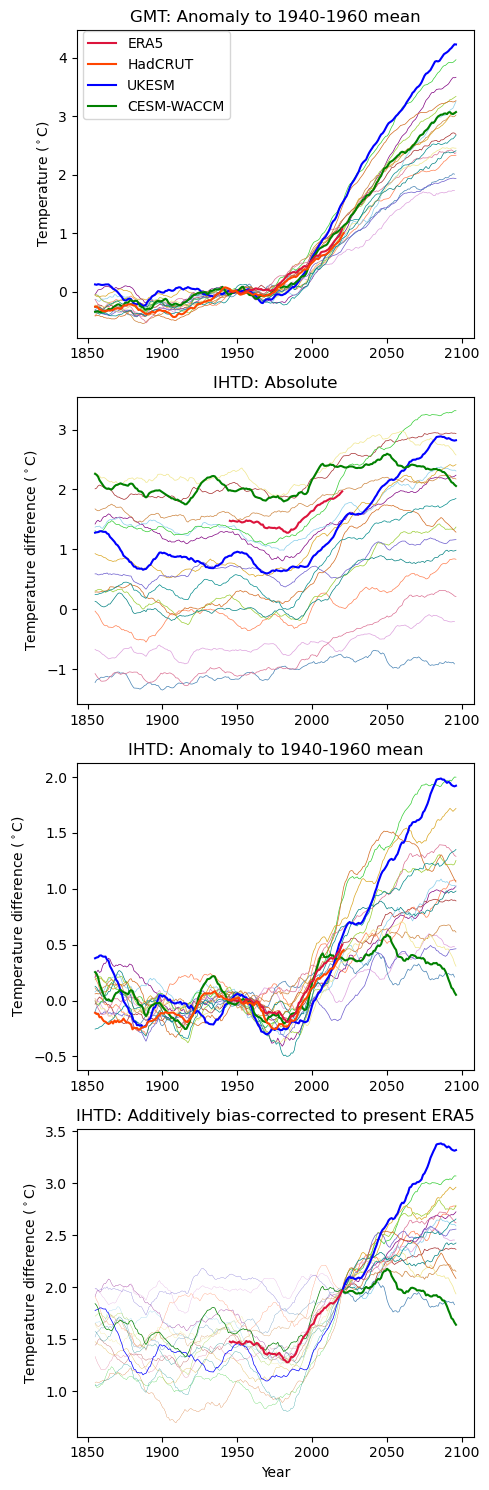

In [16]:
fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(5, 15),
)

def grid_models(rng,i):
    for c in rng:
        axes[0].plot(GMTs_anom[c].year, GMTs_anom[c].tas, color = cols[c-rng[0]], linewidth = 0.5)
        axes[3].plot(ITDs_through_present_before[c].year, ITDs_through_present_before[c].tas, color = cols[c-rng[0]], linewidth = 0.2)
        axes[3].plot(ITDs_through_present_after[c].year, ITDs_through_present_after[c].tas, color = cols[c-rng[0]], linewidth = 0.5)
        axes[1].plot(ITDs_mean[c].year, ITDs_mean[c].tas, color = cols[c-rng[0]], linewidth = 0.5)
        axes[2].plot(ITDs_anom[c].year, ITDs_anom[c].tas, color = cols[c-rng[0]], linewidth = 0.5)

grid_models(range(len(GMTs_mean)-2),0)  

uT = axes[0].plot(GMTs_anom[-2].year, GMTs_anom[-2].tas, color = 'blue', linewidth = 1.5, label='UKESM')[0]
axes[3].plot(ITDs_through_present_before[-2].year, ITDs_through_present_before[-2].tas, color = 'blue', linewidth = 0.5, label='UKESM')[0]
axes[3].plot(ITDs_through_present_after[-2].year, ITDs_through_present_after[-2].tas, color = 'blue', linewidth = 1.5, label='UKESM')[0]
uITD = axes[1].plot(ITDs_mean[-2].year, ITDs_mean[-2].tas, color = 'blue', linewidth = 1.5, label='UKESM')[0]
axes[2].plot(ITDs_anom[-2].year, ITDs_anom[-2].tas, color = 'blue', linewidth = 1.5, label='UKESM')[0]

cT = axes[0].plot(GMTs_anom[-1].year, GMTs_anom[-1].tas, color = 'green', linewidth = 1.5, label='CESM-WACCM')[0]
axes[3].plot(ITDs_through_present_before[-1].year, ITDs_through_present_before[-1].tas, color = 'green', linewidth = 0.5, label='CESM-WACCM')[0]
axes[3].plot(ITDs_through_present_after[-1].year, ITDs_through_present_after[-1].tas, color = 'green', linewidth = 1.5, label='CESM-WACCM')[0]
cITD = axes[1].plot(ITDs_mean[-1].year, ITDs_mean[-1].tas, color = 'green', linewidth = 1.5, label='CESM-WACCM')[0]
axes[2].plot(ITDs_anom[-1].year, ITDs_anom[-1].tas, color = 'green', linewidth = 1.5, label='CESM-WACCM')[0]

eT = axes[0].plot(GMT_era5_anom.year, GMT_era5_anom.t2m, color = 'crimson', linewidth = 1.5, label='ERA5')[0]
axes[3].plot(ITD_era5_10.year, ITD_era5_10.t2m, color = 'crimson', label = 'ERA5', linewidth = 1.5)
eITD = axes[1].plot(ITD_era5_10.year, ITD_era5_10.t2m, color = 'crimson', linewidth = 1.5, label='ERA5')[0]
axes[2].plot(era5_anom.year, era5_anom.t2m, color = 'crimson', linewidth = 1.5, label='ERA5')

hT = axes[0].plot(GMT_hc_anom.time, GMT_hc_anom, color = 'orangered', linewidth = 1.5, label='HadCRUT')[0]
axes[2].plot(hc_anom.time, hc_anom, color = 'orangered', linewidth = 1.5, label='HadCRUT')

axes[0].set_title(f'GMT: Anomaly to {pi_base_str} mean')
axes[3].set_title('IHTD: Additively bias-corrected to present ERA5') 
axes[1].set_title('IHTD: Absolute')
axes[2].set_title(f'IHTD: Anomaly to {pi_base_str} mean')
axes[3].set_xlabel('Year')

axes[0].set_ylabel('Temperature ($^\circ$C)')
axes[3].set_ylabel('Temperature difference ($^\circ$C)')
axes[1].set_ylabel('Temperature difference ($^\circ$C)')
axes[2].set_ylabel('Temperature difference ($^\circ$C)')

'''
axes[0].plot([2035, 2035], [-1,4], color = 'gray', linewidth = 0.5)
axes[3].plot([2035, 2035], [0.5,3.5], color = 'gray', linewidth = 0.5)
axes[1].plot([2035, 2035], [-1,3], color = 'gray', linewidth = 0.5)
axes[2].plot([2035, 2035], [-1,3], color = 'gray', linewidth = 0.5)

axes[0].plot([2025, 2025], [-1,4], color = 'gray', linewidth = 0.5)
axes[3].plot([2025, 2025], [0.5,3.5], color = 'gray', linewidth = 0.5)
axes[1].plot([2025, 2025], [-1,3], color = 'gray', linewidth = 0.5)
axes[2].plot([2025, 2025], [-1,3], color = 'gray', linewidth = 0.5)
'''
axes[0].legend(handles=[eT, hT, uT, cT], 
           loc='upper center', ncol=1, bbox_to_anchor=(0.2, 1.02), fontsize=10)

plt.tight_layout()
plt.savefig('figures/multimodels_IHTD_e5_UKESM_CESM.jpg', dpi=350)

# Plotting Precip and TPC

In [17]:
# era5 centroid 
era5_precip_trop = era5_precip.sel(latitude = slice(20,-20))

weights = np.cos(np.deg2rad(era5_precip_trop.latitude))
da_pr_zonal = era5_precip_trop.mean(dim='longitude').to_array()
da_pr_zonal_weighted = da_pr_zonal*weights
pr_weighted_lats = era5_precip_trop.latitude.weighted(da_pr_zonal_weighted)
er_yr = pr_weighted_lats.mean(dim='latitude')
era5_centroid = er_yr.rolling(year=10, center=True).mean().dropna("year")

# era5 centroid anom 

pi = era5_centroid.sel(year = pi_base).mean()
era5_cr_anom = era5_centroid - pi

In [18]:
#tropical precip 

trop_pr_w = []
weights = np.cos(np.deg2rad(trop_pr[5].y))
for i in range(len(trop_pr)):
    trop_pr_mean_w = trop_pr[i].weighted(weights).mean(dim = ['x', 'y'])
    trop_pr_mean_w = trop_pr[i].mean(dim = ['x', 'y'])
    trop_pr_w.append(trop_pr_mean_w)

era5_weights = np.cos(np.deg2rad(era5_precip_trop.latitude))
era5_trop_w = era5_precip_trop.weighted(era5_weights)
era5_trop_yrly  = era5_trop_w.mean(dim = ['latitude', 'longitude'])


era5_trop = era5_trop_yrly.rolling(year=10, center=True).mean().dropna("year")

In [19]:
# anomaly trop

trop_pr_anom = []
for i in range(len(trop_pr_w)):
    pi = trop_pr_w[i].sel(year = pi_base).mean()
    trop_anom = trop_pr_w[i] - pi 
    trop_pr_anom.append(trop_anom)

era5_pi = era5_trop.sel(year = pi_base).mean()
era5_trop_anom = era5_trop - era5_pi

In [20]:
# anomaly centroid

centroids_anom = []
for i in range(len(centroids)):
    pi = centroids[i].sel(year = pi_base).mean()
    cent_anom = centroids[i] - pi 
    centroids_anom.append(cent_anom)

In [21]:
# centroids throuhg present era5

present_era5 = era5_centroid[-1][-1]

TPCs_through_present = []
TPCs_through_present_before = []
TPCs_through_present_after = []
for i in centroids:
    s= range(len(centroids))
    diff = i.sel(year = 2020).y - present_era5
    i_through_present = i - diff
    i_bef = i_through_present.sel(year = slice(1850,2020))
    i_after = i_through_present.sel(year = slice(2020,2100))
    TPCs_through_present.append(i_through_present)
    TPCs_through_present_before.append(i_bef)
    TPCs_through_present_after.append(i_after)


<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:38: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:38: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_575/1919949802.py:37: SyntaxWarning: invalid escape sequence '\c'
  axes[3].set_ylabel('Latitude ($^\circ$)')
/tmp/ipykernel_575/1919949802.py:38: SyntaxWarning: invalid escape sequence '\c'
  axes[1].set_ylabel('Latitude ($^\circ$)')
/tmp/ipykernel_575/1919949802.py:40: SyntaxWarning: invalid escape sequence '\c'
  axes[2].set_ylabel('Latitude ($^\circ$)')


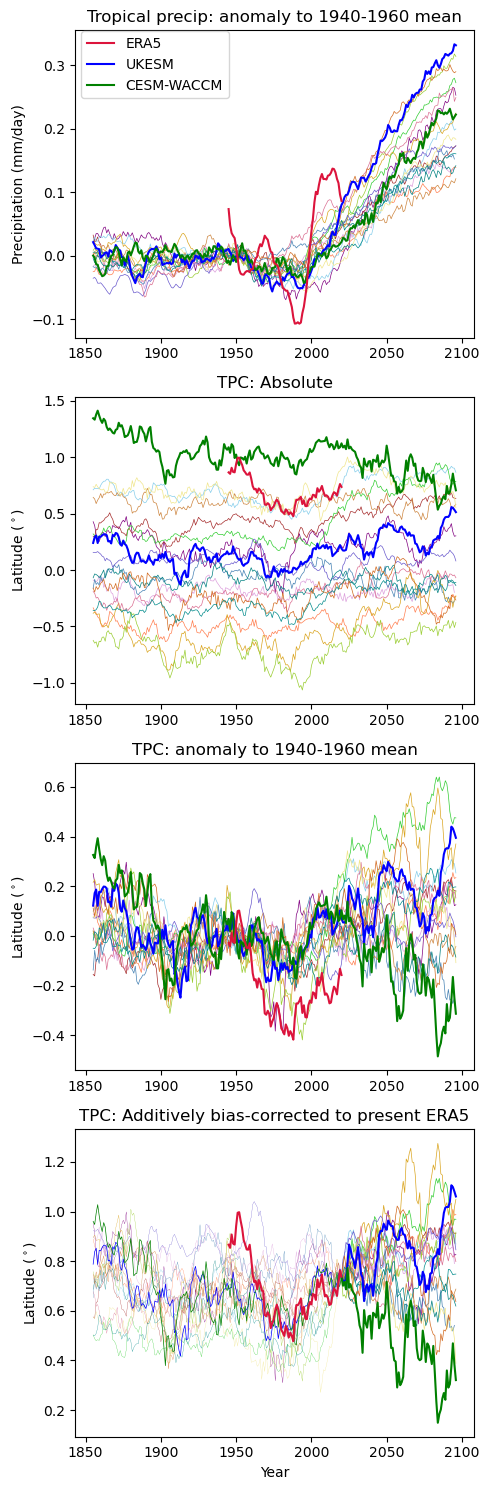

In [22]:
fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(5, 15),)

def grid_models(rng,i):
    for c in rng:
        axes[3].plot(TPCs_through_present_before[c].year, TPCs_through_present_before[c].y, color = cols[c-rng[0]], linewidth = 0.2)
        axes[3].plot(TPCs_through_present_after[c].year, TPCs_through_present_after[c].y, color = cols[c-rng[0]], linewidth = 0.5)
        axes[1].plot(centroids[c].year, centroids[c].y, color = cols[c-rng[0]], linewidth = 0.5)
        axes[0].plot(trop_pr_anom[c].year, trop_pr_anom[c].pr, color = cols[c-rng[0]], linewidth = 0.5)
        axes[2].plot(centroids_anom[c].year, centroids_anom[c].y, color = cols[c-rng[0]], linewidth = 0.5)

grid_models(range(len(trop_pr_w)-2),0)  

axes[3].plot(TPCs_through_present_before[-2].year, TPCs_through_present_before[-2].y, color = 'blue', linewidth = 0.5, label='UKESM')[0]
uT = axes[3].plot(TPCs_through_present_after[-2].year, TPCs_through_present_after[-2].y, color = 'blue', linewidth = 1.5, label='UKESM')[0]
axes[1].plot(centroids[-2].year, centroids[-2].y, color = 'blue', linewidth = 1.5, label='UKESM')[0]
axes[0].plot(trop_pr_anom[-2].year, trop_pr_anom[-2].pr, color = 'blue', linewidth = 1.5, label='UKESM')[0]
axes[2].plot(centroids_anom[-2].year, centroids_anom[-2].y, color = 'blue', linewidth = 1.5, label='UKESM')[0]

axes[3].plot(TPCs_through_present_before[-1].year, TPCs_through_present_before[-1].y, color = 'green', linewidth = 0.5, label='CESM-WACCM')[0]
cT = axes[3].plot(TPCs_through_present_after[-1].year, TPCs_through_present_after[-1].y, color = 'green', linewidth = 1.5, label='CESM-WACCM')[0]
axes[1].plot(centroids[-1].year, centroids[-1].y, color = 'green', linewidth = 1.5, label='CESM-WACCM')[0]
axes[0].plot(trop_pr_anom[-1].year, trop_pr_anom[-1].pr, color = 'green', linewidth = 1.5, label='CESM-WACCM')[0]
axes[2].plot(centroids_anom[-1].year, centroids_anom[-1].y, color = 'green', linewidth = 1.5, label='CESM-WACCM')[0]

eT = axes[3].plot(era5_centroid.year, era5_centroid[0], color = 'crimson', linewidth = 1.5, label='ERA5')[0]
axes[1].plot(era5_centroid.year, era5_centroid[0], color = 'crimson', label = 'ERA5', linewidth = 1.5)
axes[0].plot(era5_trop_anom.year, era5_trop_anom.tp *1000, color = 'crimson', linewidth = 1.5, label='ERA5')[0]
axes[2].plot(era5_cr_anom.year, era5_cr_anom[0], color = 'crimson', linewidth = 1.5, label='ERA5')

axes[3].set_title(f'TPC: Additively bias-corrected to present ERA5')
axes[1].set_title('TPC: Absolute')
axes[0].set_title(f'Tropical precip: anomaly to {pi_base_str} mean')
axes[2].set_title(f'TPC: anomaly to {pi_base_str} mean')
axes[3].set_xlabel('Year')

axes[3].set_ylabel('Latitude ($^\circ$)')
axes[1].set_ylabel('Latitude ($^\circ$)')
axes[0].set_ylabel('Precipitation (mm/day)')
axes[2].set_ylabel('Latitude ($^\circ$)')

axes[0].legend(handles=[eT, uT, cT], 
           loc='upper center', ncol=1, bbox_to_anchor=(0.2, 1.02), fontsize=10)

plt.tight_layout()
plt.savefig('figures/multimodels_TPC_e5_UKESM_CESM.jpg', dpi=350)

# Precipitation by region 

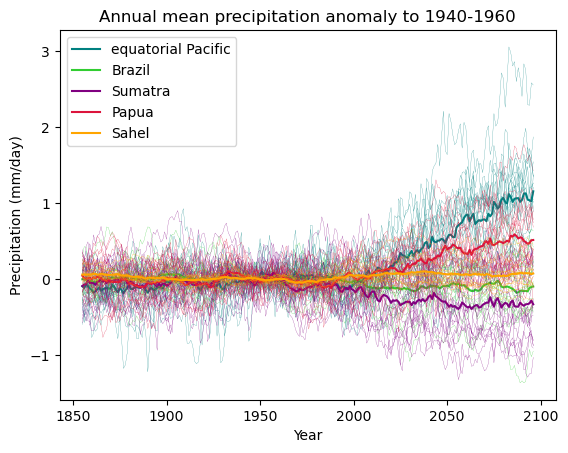

In [23]:

x_SriLanka = slice(75,85)
y_SriLanka = slice(0,10)
pr_SL = []
da_SL = []
clr_SI = 'red'
name_SI = 'Sri Lanka'
SriLanka = [x_SriLanka, y_SriLanka, pr_SL, da_SL, clr_SI, name_SI]

x_Brazil = slice(310,330)
y_Brazil = slice(-20,-10)
pr_Br = []
da_Br =[]
clr_Br = 'limegreen'
name_Br = 'Brazil'
Brazil = [x_Brazil, y_Brazil, pr_Br, da_Br, clr_Br, name_Br]

x_Indonesia = slice(120,140)
y_Indonesia = slice(-10,10)
pr_In = []
da_In = []
clr_In = 'darkorange'
name_In = 'Indonesia'
Indonesia = [x_Indonesia, y_Indonesia, pr_In, da_In, clr_In, name_In]

# Sumatra 
x_Sum = slice(95,105)
y_Sum = slice(-10,5)
pr_Sum = []
da_Sum = []
clr_Sum = 'purple'
name_Sum = 'Sumatra'
Sumatra = [x_Sum, y_Sum, pr_Sum, da_Sum, clr_Sum, name_Sum]

# Papua
x_Pap = slice(130,150)
y_Pap = slice(-10,0)
pr_Pap = []
da_Pap = []
clr_Pap = 'crimson'
name_Pap = 'Papua'
Papua = [x_Pap, y_Pap, pr_Pap, da_Pap, clr_Pap, name_Pap]

# Sahel 
x_Sah = slice(345,360)
y_Sah = slice(10,20)
pr_Sah = []
da_Sah = []
clr_Sah = 'orange'
name_Sah = 'Sahel'
Sahel = [x_Sah, y_Sah, pr_Sah, da_Sah, clr_Sah, name_Sah]

# Pacific 
x_Pac = slice(160,260)
y_Pac = slice(-5,5)
pr_Pac = []
da_Pac = []
clr_Pac = 'teal'
name_Pac = 'equatorial Pacific'
Pacific = [x_Pac, y_Pac, pr_Pac, da_Pac, clr_Pac, name_Pac]

regional_params = [Pacific, Brazil, Sumatra, Papua, Sahel]

for param in regional_params:
    for i in range(len(trop_pr)):
        pr = trop_pr[i].sel(x = param[0], y = param[1]).mean(dim = ['x','y'])
        pr_anom = pr - pr.sel(year = pi_base).mean()
        pr_anom.pr.plot(color = param[4], linewidth = 0.15)
        param[2].append(pr_anom.pr)
    param[3] = xr.concat(param[2],dim = 'pr')
    param[3].mean(dim = 'pr').plot(color = param[4], label = param[5])
    plt.legend(fontsize = 10)
    plt.ylabel('Precipitation (mm/day)')
    plt.xlabel('Year')
    plt.title(f'Annual mean precipitation anomaly to {pi_base_str}')

plt.savefig('figures/rain_regions.jpg', dpi = 350)

# Scatter IHTD v TPC

In [24]:
# adjust ITDs_anoms to pi = 1850-1900
pi_base, pi_base_str = slice(1850,1900), '1850-1900'   # mostly for plotting 
#pi_base, pi_base_str = slice(1940,1960), '1940-1960'  # idek

ITDs_anom = []
for i in ITDs_mean:
    anom = i - np.mean(i.sel(year = pi_base))
    ITDs_anom.append(anom)

centroids_anom = []
for i in range(len(centroids)):
    pi = centroids[i].sel(year = pi_base).mean()
    cent_anom = centroids[i] - pi 
    centroids_anom.append(cent_anom)

In [25]:
# regressions 

last_years = 50

ITDs_4reg_list = []
for i in range(len(ITDs_mean)):
    itd = ITDs_mean[i].tas[-1]
    ITDs_4reg_list.append(itd)

ITDs_4reg = np.asarray(ITDs_4reg_list)

centroids_4reg_list = []
for i in range(len(centroids)):
    c = centroids[i].y[-1]
    centroids_4reg_list.append(c)

centroids_4reg = np.asarray(centroids_4reg_list)

xseq = np.linspace(-1, 3.5, num=100)

b, a, r, p, std_err = sp.stats.linregress(ITDs_4reg, centroids_4reg)
r2 = r**2

# anoms

ITDs_anom_4reg_20_list = []
for i in range(len(ITDs_anom)):
    itd = ITDs_anom[i].tas[-last_years:].mean()
    ITDs_anom_4reg_20_list.append(itd)
ITDs_anom_4reg_20 = np.asarray(ITDs_anom_4reg_20_list)

ITDs_anom_4reg_list = []
for i in range(len(ITDs_anom)):
    itd = ITDs_anom[i].tas[-1].mean()
    ITDs_anom_4reg_list.append(itd)    
ITDs_anom_4reg = np.asarray(ITDs_anom_4reg_list)

centroids_anom_4reg_20_list = []
for i in range(len(centroids_anom)):
    c = centroids_anom[i].y[-last_years:].mean()
    centroids_anom_4reg_20_list.append(c)
centroids_anom_4reg_20 = np.asarray(centroids_anom_4reg_20_list)

centroids_anom_4reg_list = []
for i in range(len(centroids_anom)):
    c = centroids_anom[i].y[-1].mean()
    centroids_anom_4reg_list.append(c)
centroids_anom_4reg = np.asarray(centroids_anom_4reg_list)


xseq_anom = np.linspace(0, 2, num=100)

b_anom, a_anom, r_anom, p_anom, std_err_anom = sp.stats.linregress(ITDs_anom_4reg_20, centroids_anom_4reg_20)
r2_anom = r_anom**2

In [26]:
# get last x years for each ITD-TPC (x defined in previous cell)

ITDs_mean_last30 = []
ITDs_anom_last30 = []

TPCs_mean_last30 = []
TPCs_anom_last30 = []

for i in range(len(ITDs_mean)):
    ITD_m_last30 = ITDs_mean[i].tas[-last_years:].mean()
    ITD_a_last30 = ITDs_anom[i].tas[-last_years:].mean()
    TPC_m_last30 = centroids[i].y[-last_years:].mean()
    TPC_a_last30 = centroids_anom[i].y[-last_years:].mean()
    ITDs_mean_last30.append(ITD_m_last30)
    ITDs_anom_last30.append(ITD_a_last30)
    TPCs_mean_last30.append(TPC_m_last30)
    TPCs_anom_last30.append(TPC_a_last30)

ITD_anom_era5_last30 = era5_anom.t2m[-10:].mean()  # era5 only 10 last years cause 30 is like half the whole ds
TPC_anom_era5_last30 = era5_cr_anom[0][-10:].mean()

In [27]:
# 1. Define your min/max error bounds (replace with your actual data)

ukesm_x_min, ukesm_x_max = 1.314 , 1.625 # Example values
ukesm_y_min, ukesm_y_max = 0.050, 0.239 # Example values
cesm_x_min, cesm_x_max = 0.137, 0.324   # Example values
cesm_y_min, cesm_y_max =-0.481 , -0.259   # Example values

ukesm_x_center = ITDs_anom_last30[-2]
ukesm_y_center = TPCs_anom_last30[-2]
cesm_x_center = ITDs_anom_last30[-1]
cesm_y_center = TPCs_anom_last30[-1]
'''
UKESM itd min is: 1.314 
 UKESM itd max is: 1.625
CESM itd min is: 0.137 
 CESM itd max is: 0.324
UKESM tpc min is: 0.05052911761664193 
 UKESM tpc max is: 0.239
CESM tpc min is: -0.481 
 CESM tpc max is: -0.259
'''

ukesm_x_err = [[abs(ukesm_x_center - ukesm_x_min)], [abs(ukesm_x_max - ukesm_x_center)]]
ukesm_y_err = [[abs(ukesm_y_center - ukesm_y_min)], [abs(ukesm_y_max - ukesm_y_center)]]
cesm_x_err = [[abs(cesm_x_center - cesm_x_min)], [abs(cesm_x_max - cesm_x_center)]]
cesm_y_err = [[abs(cesm_y_center - cesm_y_min)], [abs(cesm_y_max - cesm_y_center)]]


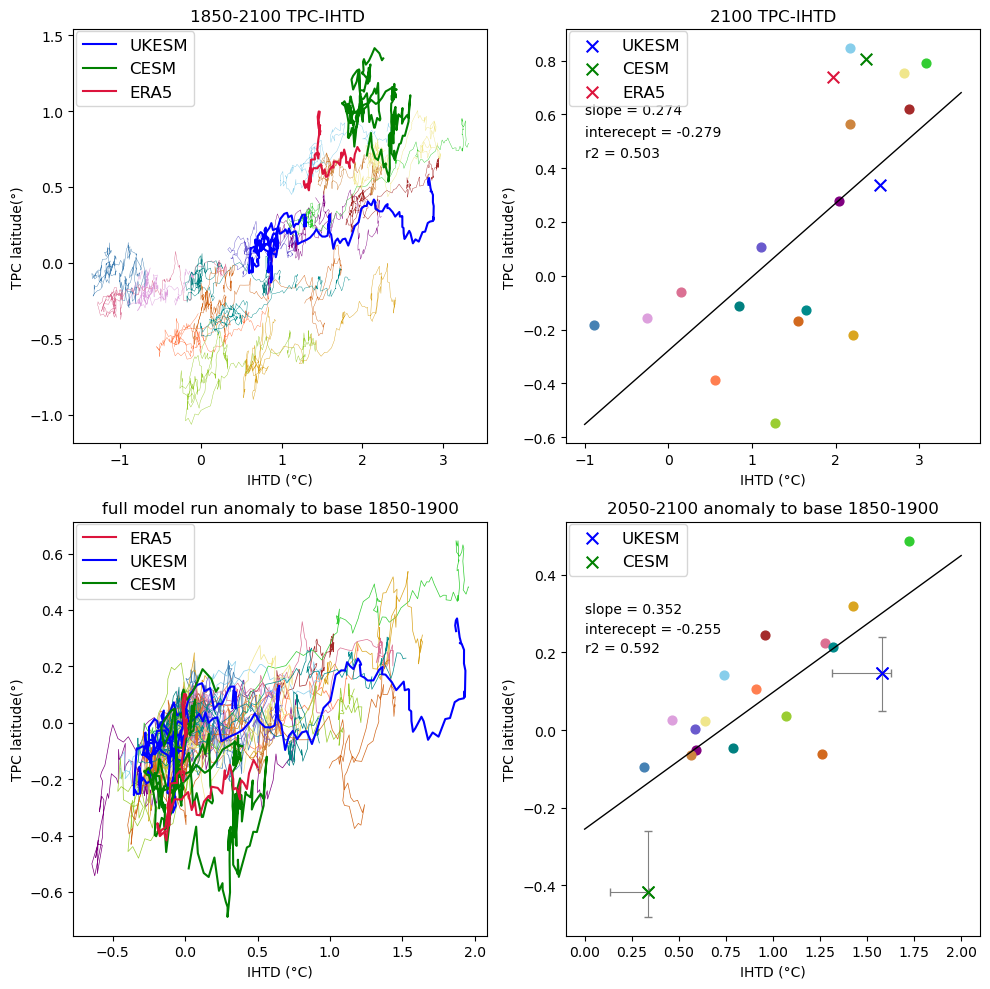

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax = axs[0,0]

for i in range(len(ITDs_mean)-2):
    ax.plot(ITDs_mean[i].tas, centroids[i].y, color = cols[i], lw=0.3)
u = ax.plot(ITDs_mean[-2].tas, centroids[-2].y, color = 'blue', label = 'UKESM', lw=1.5)[0] # UKESM
c = ax.plot(ITDs_mean[-1].tas, centroids[-1].y, color = 'green', label = 'CESM', lw=1.5)[0] # CESM
e = ax.plot(ITD_era5_10.t2m, era5_centroid[0], color = 'crimson', label = 'ERA5', lw=1.5)[0] # era5
ax.set_title('1850-2100 TPC-IHTD ')
ax.set_ylabel('TPC latitude(°)')
ax.set_xlabel('IHTD (°C)')
ax.legend(handles=[u, c, e], 
           loc='upper center', ncol=1, bbox_to_anchor=(0.15, 1.015), fontsize=12)
'''
ax = axs[0,1]
for i in range(len(ITDs_mean)-2):
    ax.scatter(ITDs_mean[i].tas[-1], centroids[i].y[-1], 40, color = cols[i])
   
u = ax.scatter(ITDs_mean[-2].tas[-1], centroids[-2].y[-1], 70, marker = 'x', color = 'blue', label = 'UKESM') # UKESM
c = ax.scatter(ITDs_mean[-1].tas[-1], centroids[-1].y[-1], 70, marker = 'x', color = 'green', label = 'CESM') # CESM
e = ax.scatter(ITD_era5_10.t2m[-1], era5_centroid[0][-1], 70, marker = 'x', color = 'crimson', label = 'ERA5') # era5
'''
# last 30 years 
ax = axs[0,1]
for i in range(len(ITDs_mean)-2):
    ax.scatter(ITDs_mean_last30[i], TPCs_mean_last30[i], 40, color = cols[i])
   
u = ax.scatter(ITDs_mean_last30[-2], TPCs_mean_last30[-2], 70, marker = 'x', color = 'blue', label = 'UKESM') # UKESM
c = ax.scatter(ITDs_mean_last30[-1], TPCs_mean_last30[-1], 70, marker = 'x', color = 'green', label = 'CESM') # CESM
e = ax.scatter(ITD_era5_10.t2m[-1], era5_centroid[0][-1], 70, marker = 'x', color = 'crimson', label = 'ERA5') # era5


ax.plot(xseq, a + b * xseq, color="k", lw=1)
b01 = f'slope = {b.round(3)}'
a01 = f'interecept = {a.round(3)}'
r01 = f'r2 = {r2.round(3)}'
ax.text(-1, 0.6, b01, fontsize=10)
ax.text(-1, 0.52, a01, fontsize=10)
ax.text(-1, 0.44, r01, fontsize=10)

ax.set_title('2100 TPC-IHTD')
ax.set_ylabel('TPC latitude(°)')
ax.set_xlabel('IHTD (°C)')
ax.legend(handles=[u, c, e], 
           loc='upper center', ncol=1, bbox_to_anchor=(0.15, 1.015), fontsize=12)

ax = axs[1,0]
for i in range(len(ITDs_anom)-2):
    ax.plot(ITDs_anom[i].tas, centroids_anom[i].y, color = cols[i], lw=0.5)
   
u = ax.plot(ITDs_anom[-2].tas, centroids_anom[-2].y,  color = 'blue', label = 'UKESM', ms=1.5)[0] # UKESM
c = ax.plot(ITDs_anom[-1].tas, centroids_anom[-1].y,  color = 'green', label = 'CESM', ms=1.5)[0] # CESM
e = ax.plot(era5_anom.t2m, era5_cr_anom[0], color = 'crimson', label = 'ERA5', ms=1.5)[0] # era5

ax.set_title('full model run anomaly to base 1850-1900')
ax.set_ylabel('TPC latitude(°)')
ax.set_xlabel('IHTD (°C)')
ax.legend(handles=[e, u, c], 
           loc='upper center', ncol=1, bbox_to_anchor=(0.15, 1.015), fontsize=12)

ax = axs[1,1]
for i in range(len(ITDs_anom)-2):
    ax.scatter(ITDs_anom_last30[i], TPCs_anom_last30[i], 40, color = cols[i])

#for i in [5,9,13]:
 #   ax.scatter(ITDs_anom_last30[i], TPCs_anom_last30[i], s = 40, c = 'white', edgecolors = df.col[i])

# 4. Plot using ax.errorbar with separate colors
u_e = ax.errorbar(ukesm_x_center, ukesm_y_center, 
                yerr=ukesm_y_err, xerr=ukesm_x_err, 
                fmt='x',
                color='blue',
                ecolor='grey',
                markersize=8,
                elinewidth=0.8,
                capsize=3,
                label='UKESM')

c_e = ax.errorbar(cesm_x_center, cesm_y_center,
                yerr=cesm_y_err, xerr=cesm_x_err,
                fmt='x',
                color='green',
                ecolor='grey',
                markersize=8,
                elinewidth=0.8,
                capsize=3,
                label='CESM')

u = ax.scatter(ITDs_anom_last30[-2], TPCs_anom_last30[-2], 70, marker = 'x',color = 'blue', label = 'UKESM') # UKESM
c = ax.scatter(ITDs_anom_last30[-1], TPCs_anom_last30[-1], 70, marker = 'x',color = 'green', label = 'CESM') # CESM
#e = ax.scatter(era5_anom.t2m[-1], era5_cr_anom[0][-1], 70, marker = 'x', color = 'crimson', label = 'ERA5') # era5
#e = ax.scatter(ITD_anom_era5_last30, TPC_anom_era5_last30, 70, marker = 'x', color = 'crimson', label = 'ERA5') # era5


ax.set_title('2050-2100 anomaly to base 1850-1900')
ax.set_ylabel('TPC latitude(°)')
ax.set_xlabel('IHTD (°C)')
ax.legend(handles=[u, c], 
           loc='upper center', ncol=1, bbox_to_anchor=(0.15, 1.015), fontsize=12)

ax.plot(xseq_anom, a_anom + b_anom * xseq_anom, color="k", lw=1)
b11 = f'slope = {b_anom.round(3)}'
a11 = f'interecept = {a_anom.round(3)}'
r11 = f'r2 = {r2_anom.round(3)}'
ax.text(0, 0.3, b11, fontsize=10)
ax.text(0, 0.25, a11, fontsize=10)
ax.text(0, 0.2, r11, fontsize=10)

plt.tight_layout()
plt.savefig('figures/scatter_4_ITD_TPC.jpg', dpi=350)

In [29]:
# determine TPC, IHTD correlation in each model 

ext, extent = slice(1850,2100), '1850-2100'
#ext, extent = slice(1944,2020), '1940-2025'  # era5 extent 

b_mods_list, a_mods_list, r_mods_list, r2_mods_list, p_mods_list = [], [], [], [], []
for i in range(len(ITDs_mean)):
    b, a, r, p, std_err = sp.stats.linregress(np.asarray(ITDs_anom[i].sel(year = ext).tas), np.asarray(centroids_anom[i].sel(year = ext).y))
    b_mods_list.append(b)
    a_mods_list.append(a)
    r_mods_list.append(r)
    r2 = r**2
    r2_mods_list.append(r2)
    p_mods_list.append(p)
b_mods = np.asarray(b_mods_list)
a_mods = np.asarray(a_mods_list)
r_mods = np.asarray(r_mods_list)
r2_mods = np.asarray(r2_mods_list)
p_mods = np.asarray(p_mods_list)

b_era, a_era, r_era, p_era, std_era = sp.stats.linregress(np.asarray(era5_anom.t2m), np.asarray(era5_cr_anom[0]))
r2_era = r_era**2

In [30]:
# copied from gettingModels.ipynb
mods_list = ['TaiESM1',
 'AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'CAS-ESM2-0',
 'IITM-ESM',
 'CanESM5',
 'ACCESS-ESM1-5',
 'ACCESS-CM2',
 'FIO-ESM-2-0',
 'INM-CM4-8',
 'KIOST-ESM',
 'MRI-ESM2-0',
 'GISS-E2-1-G',
 'KACE-1-0-G',
 'NESM3',
 'UKESM1-0-LL',
 'CESM2-WACCM' ]

In [31]:
ITDs_anom_da = []
for i in range(len(ITDs_anom)):
    ITDs_an_da = np.asarray(ITDs_anom[i].tas)
    ITDs_an_da = ITDs_an_da[:241]
    ITDs_anom_da.append(ITDs_an_da)

TPCs_anom_da = []
for i in range(len(centroids_anom)):
    TPCs_an_da = np.asarray(centroids_anom[i].y)
    TPCs_an_da = TPCs_an_da[:241]
    TPCs_anom_da.append(TPCs_an_da)

GMTs_anom_da = []
for i in range(len(GMTs_anom)):
    GMTs_an_da = np.asarray(GMTs_anom[i].tas)
    GMTs_an_da = GMTs_an_da[:241]
    GMTs_anom_da.append(GMTs_an_da)

In [38]:
# save df to get this to transfer this to CIDER notebook

df_years = np.arange(1855,2096,1)
len(df_years)

df = pd.DataFrame({
    'model': mods_list,
    'itd_anom': ITDs_anom_da,
    'tpc_anom': TPCs_anom_da,
    'gmt_anom': GMTs_anom_da,
    'slope': b_mods,
    'inter': a_mods,
    'r': r_mods,
    'r2': r2_mods, 
    'p': p_mods,
    'col': cols
})

df.to_pickle('cider/CIDER/CIDER_showcase/extra2plot/df_pickle') # change to your path
era5_anom_df = era5_anom.to_dataframe()
era5_anom_df.to_pickle('cider/CIDER/CIDER_showcase/extra2plot/era5_itd') # change to your path

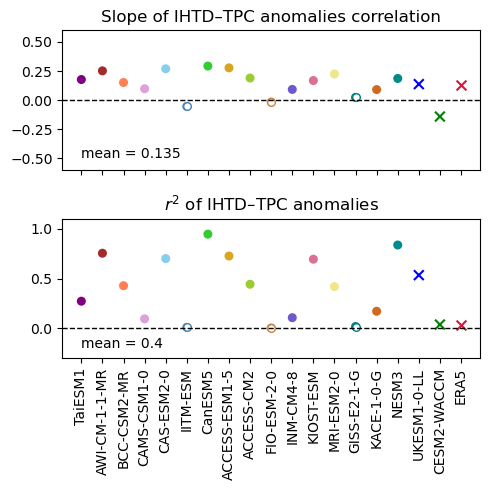

In [33]:
# plot with r squared 

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 5))

all_models = df.model.tolist() + ['ERA5']

ax = axs[1]
ax.axhline(0, color='k', linewidth=1, linestyle='--')
#ax.axhline(0.14**2, color = 'grey', linewidth = 1, ls = '--')
#ax.axhline(-(0.14**2), color = 'grey', linewidth = 1, ls = '--')

ax.scatter(df.model[:16], df.r2[:16], s=30, c=df.col[:16])
for i in [5,9,13]:
    ax.scatter(df.model[i], df.r2[i], s = 30, c = 'white', edgecolors = df.col[i])
ax.scatter(df.model[16:], df.r2[16:], marker='x', s=50, c=df.col[16:])
ax.scatter('ERA5', r2_era, marker='x', s=50, c='crimson')

ax.set_title(f'$r^2$ of IHTD–TPC anomalies')
ax.set_xticks(range(len(all_models)))
ax.set_xticklabels(all_models, rotation=90)
ax.set_ylim(-0.3, 1.1)
ax.text(0,-0.2, f'mean = {df.r2.mean().round(3)}')

ax = axs[0]
ax.scatter(df.model[:16], df.slope[:16], marker = 'o',s=30, c = df.col[:16])
for i in [5,9,13]:
    ax.scatter(df.model[i], df.slope[i], s = 30, c = 'white', edgecolors = df.col[i])
ax.scatter(df.model[16:], df.slope[16:], marker='x', s=50, c=df.col[16:])
ax.scatter('ERA5', b_era, marker='x', s=50, c='crimson')
ax.set_title(f'Slope of IHTD–TPC anomalies correlation')
ax.axhline(0, color='k', linewidth=1, linestyle='--')
ax.set_xticks(range(len(all_models)) )    # removes tick marks
ax.set_xticklabels([])  # removes labels
ax.set_ylim(-0.6, 0.6)
ax.text(0,-0.5, f'mean = {df.slope.mean().round(3)}')
#ax.text('*')


#plt.show()
plt.tight_layout()
plt.savefig('figures/correl_r2_1D.jpg', dpi=350)

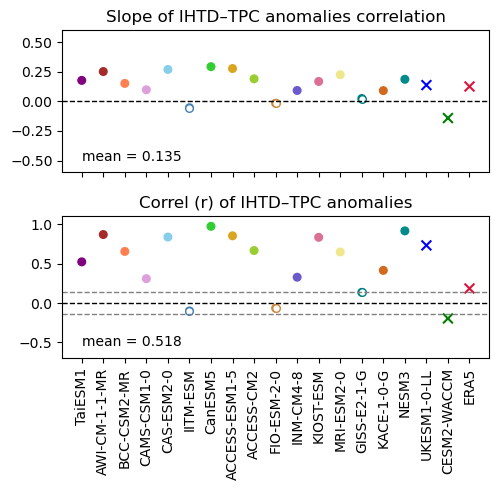

In [34]:
# plot with r

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 5))

all_models = df.model.tolist() + ['ERA5']

ax = axs[1]
ax.axhline(0, color='k', linewidth=1, linestyle='--')
ax.axhline(0.14, color = 'grey', linewidth = 1, ls = '--')
ax.axhline(-0.14, color = 'grey', linewidth = 1, ls = '--')

ax.scatter(df.model[:16], df.r[:16], s=30, c=df.col[:16])
for i in [5,9,13]:
    ax.scatter(df.model[i], df.r[i], s = 30, c = 'white', edgecolors = df.col[i])
ax.scatter(df.model[16:], df.r[16:], marker='x', s=50, c=df.col[16:])
ax.scatter('ERA5', r_era, marker='x', s=50, c='crimson')

ax.set_title(f'Correl (r) of IHTD–TPC anomalies')
ax.set_xticks(range(len(all_models)))
ax.set_xticklabels(all_models, rotation=90)
ax.set_ylim(-0.7, 1.1)
ax.text(0,-0.55, f'mean = {df.r.mean().round(3)}')

ax = axs[0]
ax.scatter(df.model[:16], df.slope[:16], s=30, c=df.col[:16])
for i in [5,9,13]:
    ax.scatter(df.model[i], df.slope[i], s = 30, c = 'white', edgecolors = df.col[i])
ax.scatter(df.model[16:], df.slope[16:], marker='x', s=50, c=df.col[16:])
ax.scatter('ERA5', b_era, marker='x', s=50, c='crimson')
ax.set_title(f'Slope of IHTD–TPC anomalies correlation')
ax.axhline(0, color='k', linewidth=1, linestyle='--')
ax.set_xticks(range(len(all_models)) )    # removes tick marks
ax.set_xticklabels([])  # removes labels
ax.set_ylim(-0.6, 0.6)
ax.text(0,-0.5, f'mean = {df.slope.mean().round(3)}')
#ax.text('*')


#plt.show()
plt.tight_layout()
plt.savefig('figures/correl_r_1D.jpg', dpi=350)

In [ ]:
print(f'UKESM slope is {df.slope[16]}, CESM slope is {df.slope[17]}')


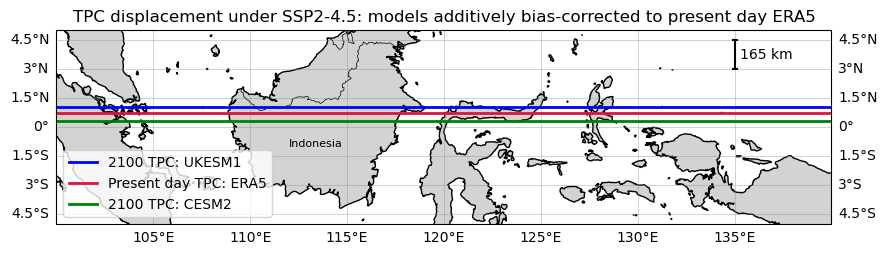

In [35]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a map with PlateCarree projection (good for lat/lon)
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and a grid
ax.coastlines()
gl = ax.gridlines(draw_labels={'bottom': True, 'left': True, 'right': True, 'top': False}, 
                    linewidth=0.5, color='gray', alpha=0.5)

# Add natural features for context
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Set global extent
ax.set_global()

# Choose latitudes
lat_era = 0.73 # e.g., green line at 45°N
lat_UKESM = 1.03  # e.g., blue line at 30°S
lat_CESM = 0.32

# Plot horizontal lines (constant latitude, full longitude range)
c = ax.plot([-180, 180], [lat_CESM, lat_CESM], color='green', linewidth=2, label=f'2100 TPC: CESM2')[0]
u = ax.plot([-180, 180], [lat_UKESM, lat_UKESM], color='blue', linewidth=2, label=f'2100 TPC: UKESM1')[0]
e = ax.plot([-180, 180], [lat_era, lat_era], color='crimson', linewidth=2, label=f'Present day TPC: ERA5')[0]

# Optional: Add legend
ax.legend(handles=[u, e, c], loc='lower left')

ax.plot([135, 135], [3,4.5], c = 'k', lw = 1.5)
ax.plot([134.9, 135.1], [3,3], c = 'k', lw = 1.5)
ax.plot([134.9, 135.1], [4.5,4.5], c = 'k', lw = 1.5)
ax.text(135.3,3.5, f'165 km')
ax.text(112,-1, f'Indonesia', fontsize=8 )


ax.set_ylim(-5,5)
ax.set_xlim(100,140)

plt.title('TPC displacement under SSP2-4.5: models additively bias-corrected to present day ERA5')

#plt.title('World Map with Latitude Lines')

plt.savefig('figures/tpc_map_first.jpg', dpi = 350)

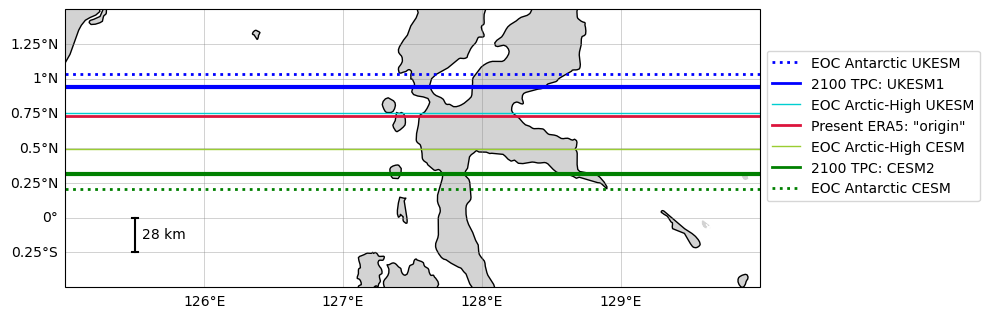

In [36]:

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a map with PlateCarree projection (good for lat/lon)
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and a grid
ax.coastlines()
gl = ax.gridlines(draw_labels={'bottom': True, 'left': True, 'right': False, 'top': False}, 
                    linewidth=0.5, color='gray', alpha=0.5)

# Add natural features for context
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')

# Set global extent
ax.set_global()


# UKESM EOC TPC for Arcitc1 is 0.06778306784759, Antarctic 0.372965531880861, SSP245 0.27412132690648716
# CESM EOC TPC for Arcitc1 is -0.22226666153196453, Antarctic -0.5132941080819624, SSP245 -0.40553160753688894

lat_era = 0.73
lat_UKESM = 1.03  
lat_CESM = 0.32

# Choose latitudes
lat_before = 0 + lat_era
lat_s245_UKESM = 0.208 + lat_era
lat_Arc_UKESM = 0.025 + lat_era # this is slightly adjusted (+0.02) so it's visible next to era5
lat_Ant_UKESM = 0.304 + lat_era

lat_s245_CESM = -0.418 + lat_era
lat_Arc_CESM = -0.238 + lat_era
lat_Ant_CESM = -0.523 + lat_era

#ax.plot([-180, 180], [lat_before, lat_before], color='k', linewidth=1, label=f'P')

e = ax.plot([-180, 180], [lat_era, lat_era], color='crimson', linewidth=2, label=f'Present ERA5: "origin"')[0]
#u = ax.plot([-180, 180], [lat_UKESM, lat_UKESM], color='blue', linewidth=3, label=f'EOC UKESM ssp245')[0]
#c = ax.plot([-180, 180], [lat_CESM, lat_CESM], color='green', linewidth=3, label=f'EOC CESM ssp245')[0]

u_s245 = ax.plot([-180, 180], [lat_s245_UKESM, lat_s245_UKESM], color='blue', linewidth=3, label=f'2100 Arctic-High UKESM')
u_arc = ax.plot([-180, 180], [lat_Arc_UKESM, lat_Arc_UKESM], color='darkturquoise', linewidth=1, label=f'EOC Arctic-High UKESM')[0]
u_ant = ax.plot([-180, 180], [lat_Ant_UKESM, lat_Ant_UKESM], color='blue', linewidth=2, ls = ':', label=f'EOC Antarctic UKESM')[0]

c_s245 = ax.plot([-180, 180], [lat_s245_CESM, lat_s245_CESM], color='green', linewidth=3, label=f'2100 TPC - CESM2')
c_arc = ax.plot([-180, 180], [lat_Arc_CESM, lat_Arc_CESM], color='yellowgreen', linewidth=1, label=f'EOC Arctic-High CESM')[0]
c_ant = ax.plot([-180, 180], [lat_Ant_CESM, lat_Ant_CESM], color='green', lw=2, ls = ':', label=f'EOC Antarctic CESM')[0]

ax.plot([125.5, 125.5], [-0.25,0], c = 'k', lw = 1.5)
ax.plot([125.48, 125.52], [-0.25,-0.25], c = 'k', lw = 1.5)
ax.plot([125.48, 125.52], [0,0], c = 'k', lw = 1.5)
ax.text(125.55,-0.15, f'28 km')

# Optional: Add legend
ax.legend(handles=[u_ant, u, u_arc, e, c_arc, c, c_ant], loc='center left', bbox_to_anchor=(1, 0.58))

ax.set_ylim(-0.5,1.5)
ax.set_xlim(125,130)

#plt.title('TPC displacement: models additively bias-corrected to present day ERA5')
plt.tight_layout()
plt.savefig('figures/tpc_map_second.jpg', dpi = 350)
plt.show()